In [69]:
ORGINAL_DATASET_PATH = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\dont_cry_corpus"
DATASET_PATH = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\dont_cry_corpus"
ORGINAL_AUDIO_DATASET = "./dataset"
AUG_AUDIO_DATASET = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\augmented_data"
FEATURES_FOLDER = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\features_lstm"
DATASET_MFCC_PATH = f"{FEATURES_FOLDER}/mfcc"
DATASET_RMS_PATH = f"{FEATURES_FOLDER}/rms"
DATASET_ZCR_PATH = f"{FEATURES_FOLDER}/zcr"
ARTICLE_RESULTS = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\article"

In [70]:
targetSampleRate = 22050
duration = 7.0
targetNumSamples = int(targetSampleRate * duration)

In [14]:
import matplotlib.pyplot as plt
import pathlib
import cv2
import numpy as np
import librosa
import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

def generate_spectrogram(stft_matrix, Fs):
    stft_matrix = np.abs(stft_matrix.T)
    
    fig = plt.figure(figsize=(2.56, 2.56), facecolor='lightgrey')

    ax = fig.add_subplot(1, 1, 1)
    powerSpectrum, frequenciesFound, time, imageAxis = ax.specgram(stft_matrix, Fs=Fs)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    
    plt.axis('on')
    return fig



def extract_features(DATASET_FILE, features_folder):
    saveTo = f"{features_folder}/spectrogram/"
    pathlib.Path(saveTo).mkdir(parents=True, exist_ok=True)

    files = sorted(list(pathlib.Path(DATASET_FILE).rglob("*.wav")))
    stft_db_matrices = []  # List to store STFT matrices and class labels
    for f in tqdm(files, total=len(files)):
        class_label = f.parts[-2]  # Extract class label from the folder name
        pathlib.Path(os.path.join(saveTo, class_label)).mkdir(parents=True, exist_ok=True)

        signal, sr = librosa.load(f, duration=5.0)
        stft_matrix = librosa.stft(signal,n_fft=2046,hop_length=2046)
        #print((len(stft_matrix)))
        stft_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=1)
        # print("Shape of stft_db before reshaping:", stft_db.shape)
        # stft_db = stft_db.reshape(128,432,1)
        # print("Shape of stft_db before reshaping:", stft_db.shape)
        # stft_db = stft_db.reshape(stft_db.shape[1], stft_db.shape[0], stft_db.shape[2])
        # stft_db = stft_db.reshape(stft_db.shape[1], stft_db.shape[0], 1)
        stft_db = stft_db.reshape(stft_db.shape[0], stft_db.shape[1], 1)

        stft_db_matrices.append((stft_db, class_label))  # Store both STFT matrix and class label
        
        # spectrogram = generate_spectrogram(stft_matrix, sr)
        # spectrogram.savefig(os.path.join(saveTo, class_label, f.stem + ".png"))

    return stft_db_matrices


if __name__ == "__main__":
    stft_db_matrices = extract_features(AUG_AUDIO_DATASET, FEATURES_FOLDER)


100%|██████████| 1939/1939 [00:23<00:00, 81.87it/s] 


In [71]:
def separate_arrays_and_labels(stft_db_matrices):
    db_arrays = []
    labels = []

    for stft_db_array, label in stft_db_matrices:
        db_arrays.append(stft_db_array)
        labels.append(label)

    return db_arrays, labels


db_arrays, labels = separate_arrays_and_labels(stft_db_matrices)


In [72]:
import numpy as np


db_arrays_np = np.array(db_arrays)
labels_np = np.array(labels)

In [77]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

if len(labels_np.shape) > 1:
    labels_np = labels_np.ravel()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_np)
y_onehot = to_categorical(y_encoded)

x = db_arrays_np
print(x.shape)

# Reshape input data for LSTM
# x = np.reshape(x, (x.shape[0], x.shape[1], 1))

x_train, x_temp, y_train, y_temp = train_test_split(x, y_onehot, train_size=0.8, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

print(y_onehot.shape[1])
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.0005))
model.add(LSTM(128))
model.add(Dropout(0.0002))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_onehot.shape[1], activation='softmax'))
# model.add(LSTM(units=128, input_shape=(54, 1024), return_sequences=True))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=8, epochs=10)

(1939, 1024, 54, 1)
5


c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 133s 661ms/step - accuracy: 0.3613 - loss: 1.3352 - val_accuracy: 0.4440 - val_loss: 1.2271
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 126s 652ms/step - accuracy: 0.4212 - loss: 1.2543 - val_accuracy: 0.5135 - val_loss: 1.1611
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 131s 675ms/step - accuracy: 0.6163 - loss: 0.8982 - val_accuracy: 0.6641 - val_loss: 0.7563
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 127s 656ms/step - accuracy: 0.6856 - loss: 0.7566 - val_accuracy: 0.7452 - val_loss: 0.7340
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 123s 636ms/step - accuracy: 0.8022 - loss: 0.5487 - val_accuracy: 0.8185 - val_loss: 0.4798
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 120s 618ms/step - accuracy: 0.8612 - loss: 0.4049 - val_accuracy: 0.8610 - val_loss: 0.3976
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 124s 639ms/step - accuracy: 0.9131 - loss: 0.2787 - val_accuracy: 0.8996 - val_loss: 0.3368
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 121s 622ms/step - accuracy: 0.9297 -

In [78]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.9134 - loss: 0.3775
Testing Loss: 0.34383639693260193
Testing Accuracy: 0.9147287011146545


[]

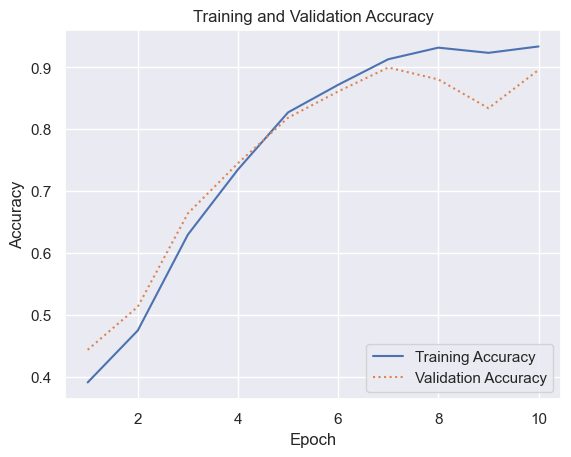

In [79]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
# test_acc = hist.history['test_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.plot()

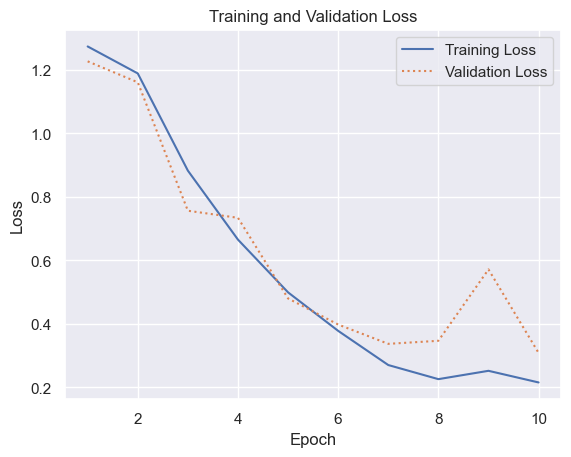

In [80]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure()

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step


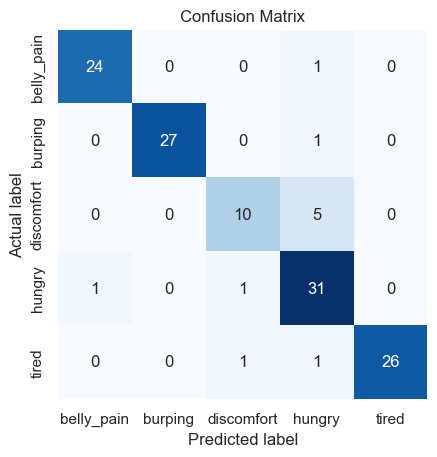

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


y_predicted = model.predict(x_test)
predicted_labels = np.argmax(y_predicted, axis=1)
actual_labels = np.argmax(y_test, axis=1)
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

mat = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')
plt.show()

In [82]:
from sklearn.metrics import classification_report

# Convert probabilities to class labels
predicted_labels = np.argmax(y_predicted, axis=1)

# Print classification report
print(classification_report(actual_labels, predicted_labels, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       0.96      0.96      0.96        25
     burping       1.00      0.96      0.98        28
  discomfort       0.83      0.67      0.74        15
      hungry       0.79      0.94      0.86        33
       tired       1.00      0.93      0.96        28

    accuracy                           0.91       129
   macro avg       0.92      0.89      0.90       129
weighted avg       0.92      0.91      0.91       129



In [83]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Calculate specificity for each class label
specificity_per_class = []
for i in range(len(class_labels)):
    true_negatives = sum(cm[j, j] for j in range(len(class_labels)) if j != i)
    false_positives = sum(cm[j, i] for j in range(len(class_labels)) if j != i)
    specificity = true_negatives / (true_negatives + false_positives)
    specificity_per_class.append(specificity)

# Print specificity for each class label
for i, label in enumerate(class_labels):
    print(f" {label}: {specificity_per_class[i]}")


 belly_pain: 0.9894736842105263
 burping: 1.0
 discomfort: 0.9818181818181818
 hungry: 0.9157894736842105
 tired: 1.0


In [68]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

if len(labels_np.shape) > 1:
    labels_np = labels_np.ravel()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_np)
y_onehot = to_categorical(y_encoded)

x = db_arrays_np


# Reshape input data for LSTM
# x = np.reshape(x, (x.shape[0], x.shape[1], 1))

x_train, x_temp, y_train, y_temp = train_test_split(x, y_onehot, train_size=0.8, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

print(y_onehot.shape[1])
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.0005))
model.add(LSTM(128))
model.add(Dropout(0.0002))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_onehot.shape[1], activation='softmax'))
# model.add(LSTM(units=128, input_shape=(54, 1024), return_sequences=True))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

5


c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 1024, 128)      │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,861 (913.52 KB)

 Trainable params: 233,861 (913.52 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
from keras.models import load_model
model.save('dsp_cry_corpus_lstm.h5')